# Steady State PDF of Double-Welled Overdamped Langevin Equation

In [1]:
using JLD
using DifferentialEquations
using Plots
pyplot()

include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction_Dev.jl")

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1278


vector_wiener_filter_fft

## Emperical PDF
From previously computed data, form parameters listed below, I compute the emperical pdf of the "double-welled" overdamped Langevin equation.

First I load the histogram and then conect the dots quadratically.

In [13]:
steps = 10^7 + 1
scheme = "FE"
t_start = 0
t_stop = 10^5
discard = 100000
sig_init = [1.5]
sigma = [.35]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


Y = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

1×10000001 Array{Float64,2}:
 -1.06307  -1.03776  -0.99853  -1.026  …  0.983695  0.955309  0.973648

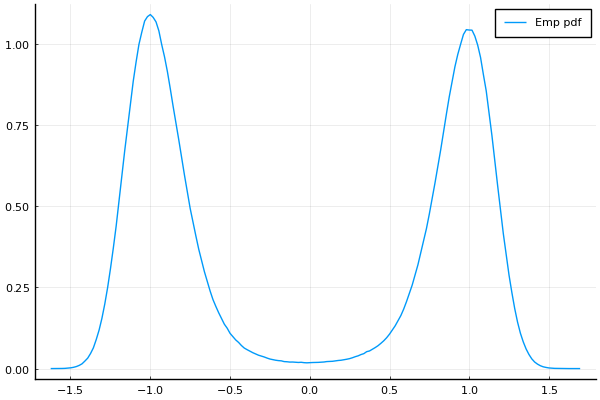

In [15]:
pdf_num, b_mpts, P = emp_pdf(Y)
plot(P)

In [16]:
function p(z)
    i = argmin(abs.(b_mpts .- z))
    if (i == 1) | (i == length(b_mpts))
        x = [1; 2; 3]
        y = zeros(3)
    else
        x = b_mpts[i-1:i+1]
        y = pdf_num[i-1:i+1]
    end
    a = [x.^2 x ones(3)] \ y
    P = a[1]*z^2 + a[2]*z + a[3]
end

p (generic function with 1 method)

## Numerical approximation of exact PDF from Fokker-Plank equation

Here we have Langevin equation
$$\frac{dx}{dt} = -u'(x) +\sigma v_t$$
where 
\begin{align}
&u(x) = \frac{1}{4}(x^2 - 1)^2, \\
&v_t \sim N(0,1)\quad \text{(i.i.d.), and} \\
&\sigma = .35.
\end{align}

The Fokker-Plank equation for the probability distribution $f(x,t)$ then is

$$\frac{\partial f}{\partial t} = \frac{\partial }{\partial x}U'(x)f + kT\frac{\partial^2 }{\partial^2 x}f$$
We seek the steady state distribution. So, $\frac{\partial f}{\partial t} = 0$.
This gives the homogenous differential equation 
$$0 = U''f + U'f' + kTf'' = (3x^2 - 1)f(x) + (x^3 - x)f'(x) + kTf''(x)$$
since here $kT = \sigma^2/2$.  

We then solve this unmerically using `DifferentialEquations.jl`.

In [25]:
σ = sigma[1]

function RHS!(dU,U,μ,t)
    dU[1] = U[2]
    dU[2] = -1/μ*(3t^2 - 1)*U[1] - 1/μ*(t^3 -t)*U[2]
end

U0 = [p(0);0] # Here we cheat and use the emperical value at 0
tspan = (0.0,2.0)

μ = σ^2/2

prob = ODEProblem(RHS!,U0,tspan,μ)
sol = solve(prob)

p_num(x) = x>=0 ? sol(x)[1] : sol(-x)[1]

p_num (generic function with 1 method)

## Try this

In [38]:
p_test(x) = exp(-(x^2-1)^2/μ/4)

p_test (generic function with 1 method)

## Compare solutions

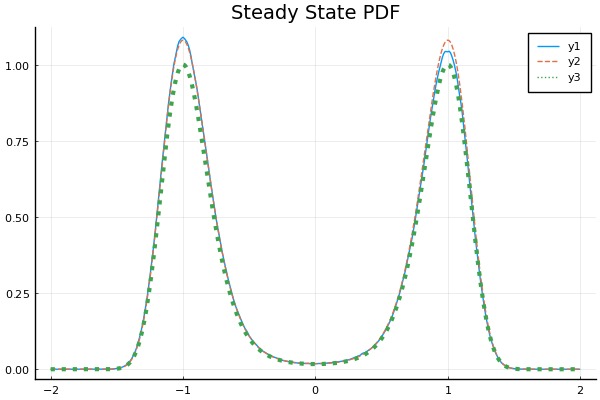

In [39]:
x = -2:0.01:2
plot(x,p.(x),lable = "Emperical pdf")
plot!(x,p_num.(x),
    line = :dash,
    lable = "Exact pdf",
    title = "Steady State PDF")
plot!(x,p_test.(x),
    line = (3,:dot),
    lable = "Exact pdf")
